In [3]:
!pip install pandas==2.0.2 scikit-learn==1.3.2 joblib==1.3.2

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Load dataset
ipi = pd.read_csv('India_Infras_Processed.csv')

In [3]:
ipi

,State/Union Territory,Power_Requirement_Net_Crore_Units_kiloWatt-Hour,Availability_Of_Power_Net_Crore_Units_kiloWatt-Hour,Installed_Power_Capacity_MegaWatt,End_Year,population(million),Region,rel_pop,rel_infras_eco,Region_means_encoded,Region_encoded_normalized,Region_encoded_standardized
0,Andhra Pradesh,5042.0,5006.0,10809.0,2005,76.206424,SR,4,3,4034.861111,0.884521,0.869195
1,Arunachal Pradesh,16.0,16.0,187.0,2005,1.111883,NER,2,2,156.970370,0.000000,-1.652227
2,Assam,379.0,358.0,1133.0,2005,26.636905,NER,4,4,156.970370,0.000000,-1.652227
3,Bihar,720.0,648.0,1644.0,2005,83.076923,ER,4,1,2331.338983,0.495959,-0.238443
4,Chandigarh,116.0,115.0,79.0,2005,0.902173,NR,1,1,3255.464052,0.706746,0.362428
...,...,...,...,...,...,...,...,...,...,...,...,...
594,Telangana,6700.0,6699.0,17218.0,2021,35.174587,SR,2,4,4034.861111,0.884521,0.869195
595,Tripura,148.0,148.0,724.0,2021,3.677019,NER,4,4,156.970370,0.000000,-1.652227
596,Uttar Pradesh,12437.0,12338.0,27896.0,2021,199.611713,NR,4,4,3255.464052,0.706746,0.362428
597,Uttarakhand,1383.0,1382.0,3731.0,2021,10.118612,NR,2,2,3255.464052,0.706746,0.362428


## We need to label encode "State/Union Territory".

Let's do as follows:


In [4]:
st_en={}
for ind, st in enumerate(ipi['State/Union Territory'].unique()):
  st_en[st]=ind
st_en #so now the states/ union territry will always be identified by same number across all time series.label encoding makes it difficult.

{'Andhra Pradesh': 0,
 'Arunachal Pradesh': 1,
 'Assam': 2,
 'Bihar': 3,
 'Chandigarh': 4,
 'Chhattisgarh': 5,
 'Dadra and Nagar Haveli': 6,
 'Daman and Diu': 7,
 'Delhi': 8,
 'Goa': 9,
 'Gujarat': 10,
 'Haryana': 11,
 'Himachal Pradesh': 12,
 'Jammu and Kashmir': 13,
 'Jharkhand': 14,
 'Karnataka': 15,
 'Kerala': 16,
 'Madhya Pradesh': 17,
 'Maharashtra': 18,
 'Manipur': 19,
 'Meghalaya': 20,
 'Mizoram': 21,
 'Nagaland': 22,
 'Odisha': 23,
 'Puducherry': 24,
 'Punjab': 25,
 'Rajasthan': 26,
 'Tamil Nadu': 27,
 'Tripura': 28,
 'Uttar Pradesh': 29,
 'Uttarakhand': 30,
 'West Bengal': 31,
 'Andaman and Nicobar Islands': 32,
 'Lakshadweep': 33,
 'Sikkim': 34,
 'Telangana': 35}

In [5]:
df=ipi.copy()

In [9]:
# Encode categorical 'State/Union Territory'
#df['State/Union Territory'] = LabelEncoder().fit_transform(df['State/Union Territory']) #label encodinggives diff value for diff yrs for same state
df['State/Union Territory']=df['State/Union Territory'].apply(lambda x:st_en[x])
# Select input and output (to be forecasted) features
features = ['State/Union Territory', 'End_Year', 'population(million)']
X = df[features]
y = df[['Power_Requirement_Net_Crore_Units_kiloWatt-Hour', 'Availability_Of_Power_Net_Crore_Units_kiloWatt-Hour']]

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42)
}

In [11]:
# Function to evaluate model
def evaluate_model(model, X, y, cv):
    r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
    neg_mae = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    return {
        'R2': np.mean(r2),
        'MAE': -np.mean(neg_mae),
        'RMSE': np.sqrt(-np.mean(neg_mse))
    }

In [12]:
# Evaluate models and compare results
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X, y, kf)

# Display results
for name, metrics in results.items():
    print(f"{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

RandomForest Results:
R2: 0.9828
MAE: 204.6737
RMSE: 441.4521

XGBRegressor Results:
R2: 0.9779
MAE: 218.1622
RMSE: 489.0444



Since R^2 so close let's check additional metric: mae, mse, rmse

##Interpreting MAE, and RMSE Scores

## Mean Absolute Error (MAE):

What it measures: The average magnitude of the errors in a set of predictions, without considering their direction (i.e., no positive/negative distinction).

Interpretation: Lower MAE values are better. A MAE of 0 means that your model is perfect, which is rarely the case. The acceptability of MAE depends on the context of your data and the scale of the target values.

## Mean Squared Error (MSE):

What it measures: The average of the squares of the errors. MSE gives greater weight to larger errors.

Interpretation: Like MAE, lower MSE values are better. A high MSE suggests that there might be large errors occurring, which could be problematic in many real-world scenarios.

## Root Mean Squared Error (RMSE):

What it measures: The square root of MSE. RMSE is in the same units as the target variable.
Interpretation: Lower RMSE values indicate a better fit. RMSE is particularly useful when large errors are particularly undesirable.


## Choosing the Best Model when comparing models:

Prefer the model with the lowest RMSE if large errors are more detrimental to your application.

MAE can be more informative when dealing with applications where all errors, regardless of their size, are equally important.
Examine MSE if you need to punish larger errors more severely than smaller ones.
When interpreting these scores, always consider the scale of your target variable. For example, an MAE of 10 might be very small if the target variable ranges in the thousands, but quite significant if the range is around 10-20. Similarly, compare these scores relative to simpler models or baseline predictions (like predicting the mean of the target) to assess their improvement over naïve approaches.



In [13]:
# Select the best model based on R2 score (or any other metric)
best_model_name = min(results, key=lambda name: results[name]['RMSE'])
best_model = models[best_model_name]

# Fit the best model on the entire dataset
best_model.fit(X, y)

RandomForestRegressor(random_state=42)

## Visualization by picking 10 random states

In [14]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns
import random

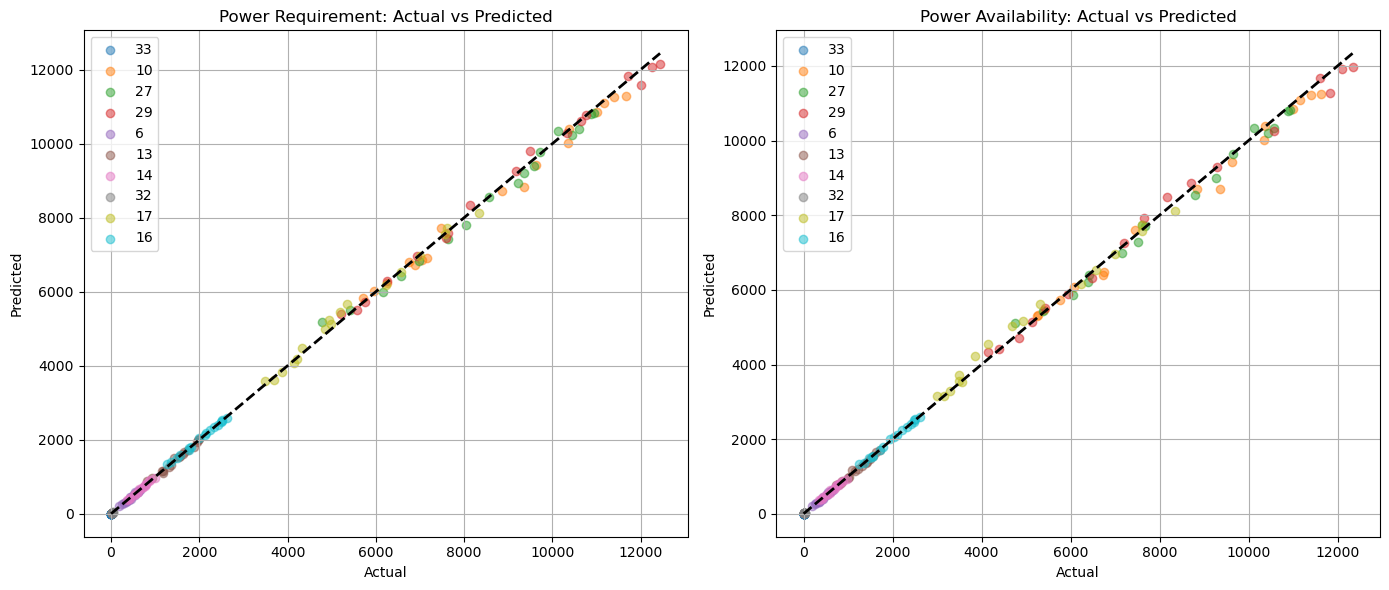

In [15]:
# Get unique states
states = df['State/Union Territory'].unique()

# Select 10 random states #index represent the encoding for a state as above
random_states = random.sample(list(states), 10)

# Filter dataset for the selected states
filtered_df = df[df['State/Union Territory'].isin(random_states)]
X_filtered = filtered_df[features]
y_filtered = filtered_df[['Power_Requirement_Net_Crore_Units_kiloWatt-Hour', 'Availability_Of_Power_Net_Crore_Units_kiloWatt-Hour']]

# Make predictions for the filtered data
y_pred_filtered = best_model.predict(X_filtered)

# Separate predictions for each target variable
y_pred_power_req_filtered = y_pred_filtered[:, 0]
y_pred_power_avail_filtered = y_pred_filtered[:, 1]

# Separate actual values for each target variable
y_actual_power_req_filtered = y_filtered.iloc[:, 0]
y_actual_power_avail_filtered = y_filtered.iloc[:, 1]

# Plot for 'Power_Requirement_Net_Crore_Units_kiloWatt-Hour'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for state in random_states:
    idx = filtered_df['State/Union Territory'] == state
    plt.scatter(y_actual_power_req_filtered[idx], y_pred_power_req_filtered[idx], alpha=0.5, label=state)
plt.plot([y_actual_power_req_filtered.min(), y_actual_power_req_filtered.max()],
         [y_actual_power_req_filtered.min(), y_actual_power_req_filtered.max()],
         color='black', linestyle='--', linewidth=2)
plt.title('Power Requirement: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)

# Plot for 'Availability_Of_Power_Net_Crore_Units_kiloWatt-Hour'
plt.subplot(1, 2, 2)
for state in random_states:
    idx = filtered_df['State/Union Territory'] == state
    plt.scatter(y_actual_power_avail_filtered[idx], y_pred_power_avail_filtered[idx], alpha=0.5, label=state)
plt.plot([y_actual_power_avail_filtered.min(), y_actual_power_avail_filtered.max()],
         [y_actual_power_avail_filtered.min(), y_actual_power_avail_filtered.max()],
         color='black', linestyle='--', linewidth=2)
plt.title('Power Availability: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# Assuming 'best_model', 'X', and 'y' are already defined
# Make predictions for the entire dataset
y_pred = best_model.predict(X)

# Separate predictions for each target variable
y_pred_power_req = y_pred[:, 0]
y_pred_power_avail = y_pred[:, 1]

# Separate actual values for each target variable
y_actual_power_req = y.iloc[:, 0]
y_actual_power_avail = y.iloc[:, 1]

# Calculate metrics for Power Requirement
mae_power_req = mean_absolute_error(y_actual_power_req, y_pred_power_req)
rmse_power_req = np.sqrt(mean_squared_error(y_actual_power_req, y_pred_power_req))
mape_power_req = mean_absolute_percentage_error(y_actual_power_req, y_pred_power_req)

# Calculate metrics for Availability of Power
mae_power_avail = mean_absolute_error(y_actual_power_avail, y_pred_power_avail)
rmse_power_avail = np.sqrt(mean_squared_error(y_actual_power_avail, y_pred_power_avail))
mape_power_avail = mean_absolute_percentage_error(y_actual_power_avail, y_pred_power_avail)

# Calculate mean actual values for percentage calculations
mean_actual_power_req = np.mean(y_actual_power_req)
mean_actual_power_avail = np.mean(y_actual_power_avail)

# Calculate MAE% and RMSE%
mae_percentage_power_req = (mae_power_req / mean_actual_power_req) * 100
rmse_percentage_power_req = (rmse_power_req / mean_actual_power_req) * 100

mae_percentage_power_avail = (mae_power_avail / mean_actual_power_avail) * 100
rmse_percentage_power_avail = (rmse_power_avail / mean_actual_power_avail) * 100

# Print the results
results = {
    'Power Requirement': {
        'MAE': mae_power_req,
        'RMSE': rmse_power_req,
        'MAPE': mape_power_req,
        'MAE%': mae_percentage_power_req,
        'RMSE%': rmse_percentage_power_req
    },
    'Availability of Power': {
        'MAE': mae_power_avail,
        'RMSE': rmse_power_avail,
        'MAPE': mape_power_avail,
        'MAE%': mae_percentage_power_avail,
        'RMSE%': rmse_percentage_power_avail
    }
}

print("Evaluation Results:")
for key, value in results.items():
    print(f"\n{key}:")
    for metric, score in value.items():
        print(f"  {metric}: {score:.2f}")

Evaluation Results:

Power Requirement:
  MAE: 57.20
  RMSE: 122.01
  MAPE: 2.78
  MAE%: 2.12
  RMSE%: 4.52

Availability of Power:
  MAE: 56.38
  RMSE: 115.86
  MAPE: 2.82
  MAE%: 2.20
  RMSE%: 4.51


## Saving the best model

In [18]:
from joblib import dump
dump(best_model, 'req_avail_simple_model.joblib')

print(f"The best model is {best_model_name} and it has been saved as 'req_avail_simple_model.joblib'")

The best model is RandomForest and it has been saved as 'req_avail_simple_model.joblib'
